In [1]:
# TODO
# get the various paths that are taken from our machine to the destination for various VPN services.
# calculate the time in multiple cases and record the average time
# take a screenshot of dns leak on ubuntu
# ping
# ping vpn server with and without vpn
# page response time

# traceroute

from statistics import mean
from scapy.all import *

IPVANISH_HOMEDIR = "/home/sanjthom/Documents"
ovpn_files = ['ipvanish-AL-Tirana-tia-c02.ovpn','ipvanish-US-New-York-nyc-a01.ovpn']

target = 'google.com'

In [2]:
# DNS Resolution
answer = sr1(IP(dst="8.8.8.8")/UDP(dport=53)/DNS(rd=1,qd=DNSQR(qname=target)),verbose=0)
target_ip = answer.an.rdata
print("DNS resolved: {} ==> {}".format(target,target_ip))

DNS resolved: google.com ==> 172.217.31.238


In [3]:
# ping with/without vpn, location specific content with vpn

def is_icmp_blocked(response):
    if not response.haslayer(ICMP):
        return True
    
    icmp_layer = response.getlayer(ICMP)
    blocked = int(icmp_layer.type) == 3 and (int(icmp_layer.code) in [1,2,3,9,10,13])
    if blocked:
        return True
    return False

def get_pingtimes(target_ip,count):
    resp_times = []
    for i in range(count):
        response = sr(IP(dst=target_ip) / ICMP(id=100),timeout=5,verbose=0)
        # first entry of response is the answered list of packet pairs
        # first entry of next list gives us ICMP packet pairs
        # the packet pair consists of packet sent and received
        if len(response) != 0:
            resp_times.append(response[0][0][1].time - response[0][0][0].time)
    return resp_times

In [4]:
ping_times = get_pingtimes(target_ip,10)
mean_pingtime = mean(ping_times)

In [33]:
# shanmukh's ip geolocation lookup
# a db of ip to  geolocation,AS mappings:
# https://dev.maxmind.com/geoip/geoip2/geolite2/

import json
import geoip2.database
from ip2geotools.databases.noncommercial import DbIpCity

try:
    db = geoip2.database.Reader("GeoLite2-ASN.mmdb")
except Exception:
    warning("Cannot open geoip2 database")

def get_location(target):
    try:
        result = json.loads(DbIpCity.get(target, api_key='free').to_json())
    except:
        result = {'city': 'Stony Brook', 'country': 'US'}
    
    try:
        asn = db.asn(target).autonomous_system_organization
    except geoip2.errors.AddressNotFoundError:
        asn = "N.A."
    #print(result)
    return result['city'],result['country'],asn


In [27]:
# TCP Traceroute
from scapy.layers.inet import traceroute
from scapy.layers.inet import traceroute_map
# ans,unans = answered,unanswered packets list
# They are of type TracerouteResult defined in scapy/inet.py
# each entry in ans is a 2-entry tuple = send,recv packet

ans,unans = traceroute(target_ip, maxttl=60, verbose=0)
index = len(ans)
for i,v in enumerate(ans):
    if v[1].src == target_ip:
        index = i
        break

# scapy parallelly sends requests for all TTL's and stores results from them.
# Removing redundant entries after the packet reaches destination
ans[0:index+1]

<mod Traceroute: TCP:1 UDP:0 ICMP:11 Other:0>

In [28]:
print("List of answered packets:")
print()
for s,d in ans[0:index+1]:
    src = s.sprintf("%-03s,IP.ttl%  %IP.dst%")
    city,country,asn = get_location(d.src)
    dst = d.sprintf("%-15s,IP.src% ("+city+","+country+")")
    print(src+" ==> "+dst)

List of answered packets:

1    172.217.31.238 ==> 172.21.24.1     (Stony Brook,US)
2    172.217.31.238 ==> 151.139.118.10  (Los Angeles,US)
3    172.217.31.238 ==> 151.139.118.3   (Los Angeles,US)
4    172.217.31.238 ==> 151.139.118.7   (Los Angeles,US)
5    172.217.31.238 ==> 122.55.210.109  (Mandaluyong City,PH)
6    172.217.31.238 ==> 210.213.130.230 (Mandaluyong City,PH)
7    172.217.31.238 ==> 210.213.128.145 (Mandaluyong City,PH)
8    172.217.31.238 ==> 210.213.131.73  (Mandaluyong City,PH)
9    172.217.31.238 ==> 72.14.203.85    (Ashburn,US)
10   172.217.31.238 ==> 108.170.241.1   (Ashburn,US)
11   172.217.31.238 ==> 72.14.234.63    (Ashburn,US)
13   172.217.31.238 ==> 172.217.31.238  (Hong Kong,HK)


In [32]:
print("Thee are {} unanswered packets.".format(len(unans)))

if len(unans) != 0:
    print("List of unanswered packets:")
    print()
    print("TTL  Source IP      Port")
    for s in unans:
        print(s.sprintf("%-03s,IP.ttl%  %IP.dst%  {TCP:%ir,TCP.dport%}{UDP:udp%ir,UDP.dport%}"))

Thee are 0 unanswered packets.


In [133]:
from subprocess import Popen,PIPE
process = Popen(['cat', 'test.py'], stdout=PIPE, stderr=PIPE)
stdout, stderr = process.communicate()
print(stdout)

b''


In [36]:
from scapy.config import conf

conf.geoip_city = "/home/sanjthom/FCN/geolite2/GeoLite2-City.mmdb"
lines = traceroute_map(target_ip)

Begin emission:
Finished sending 30 packets.

Received 22 packets, got 22 answers, remaining 8 packets
   54.185.10.135:tcp80 
1  130.245.255.1   11  
3  199.109.5.129   11  
4  199.109.7.166   11  
5  199.109.7.93    11  
6  199.109.7.194   11  
7  199.109.11.34   11  
8  162.252.70.131  11  
9  162.252.70.162  11  
10 162.252.70.107  11  
11 162.252.70.172  11  
12 64.57.30.45     11  
13 52.95.52.14     11  
14 52.95.52.59     11  
15 52.95.53.120    11  
16 54.239.42.219   11  
17 54.239.42.219   11  
19 52.93.12.162    11  
20 52.93.12.214    11  
21 52.93.246.103   11  
22 52.93.13.53     11  
29 54.185.10.135   11  
30 54.185.10.135   SA  


In [5]:
import json
import matplotlib.pyplot as plt
import numpy as np

def get_pingtimes(ping_file):
    with open(ping_file, 'r') as myfile:
        data=myfile.read()

    # parse file
    obj = json.loads(data)

    x_axes = list(obj.keys())
    # all the ping times
    total_pts = []

    for site,info in obj.items():
        pingtimes = []
        for pkt in info['icmp_replies']:
            pingtimes.append(pkt['time'])
        total_pts.append(pingtimes)

    return x_axes,total_pts

Measuring Ping Times with and without VPN services

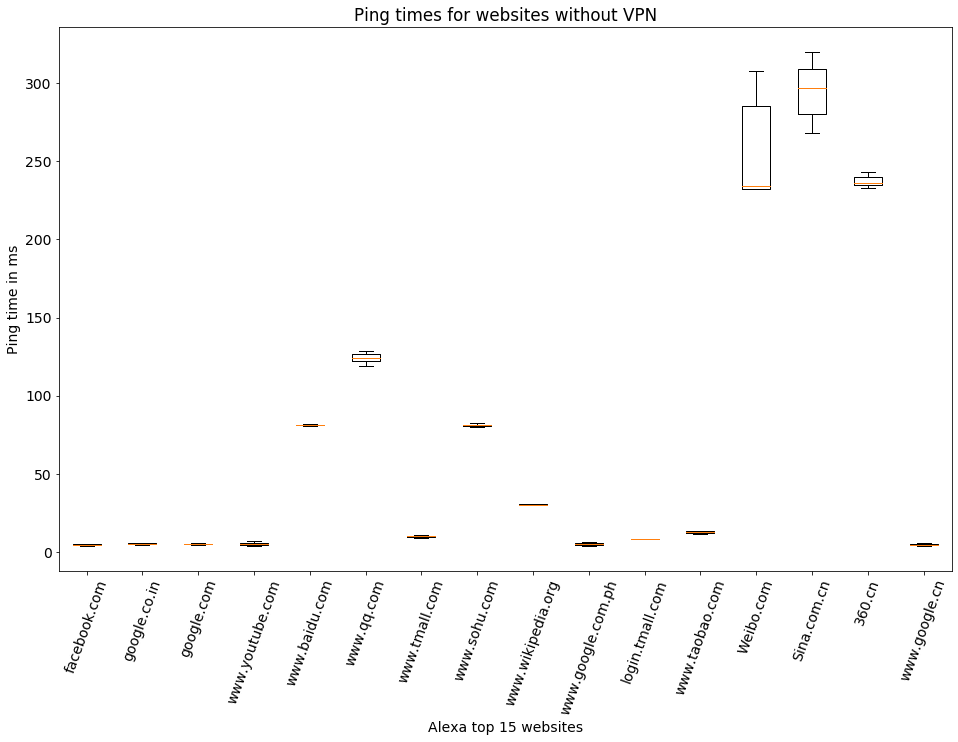

In [68]:
# Without VPN
x_axes, total_pts = get_pingtimes('pingtimes_complete.json')

plt.rcParams.update({'font.size': 14})
fig, ax = plt.subplots(figsize=(16,10))

plt.xlabel('Alexa top 15 websites')
plt.ylabel('Ping time in ms')
plt.title('Ping times for websites without VPN')
ax.set_xticklabels(x_axes)
plt.xticks(rotation=70)
plt.boxplot(total_pts, showfliers=False)
plt.show()

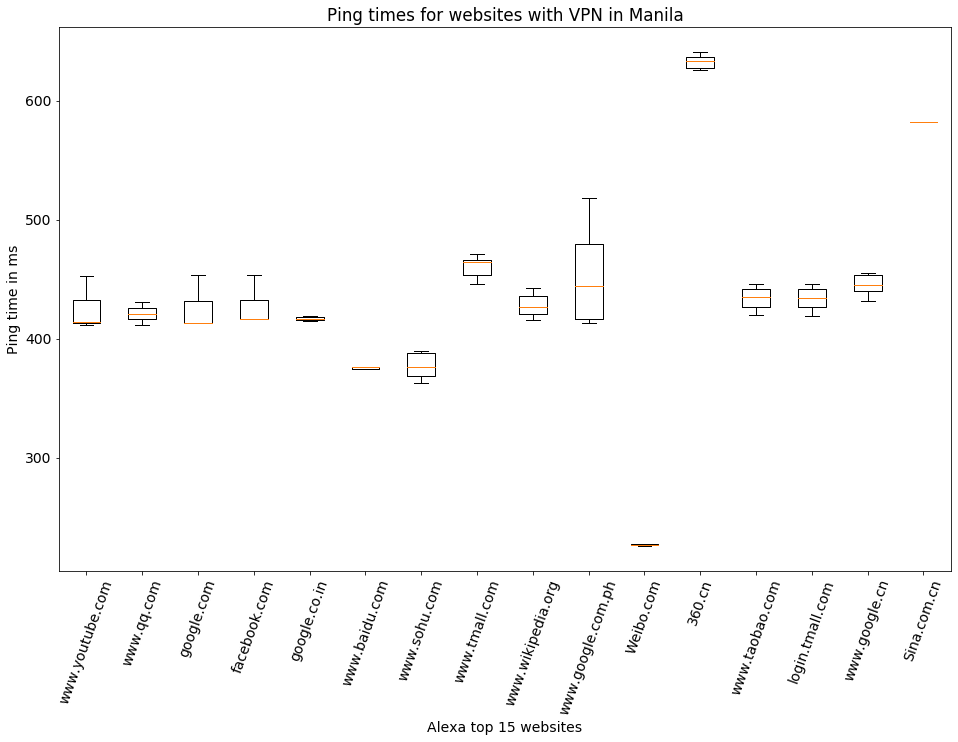

In [69]:
# With Manila VPN
x_axes, total_pts = get_pingtimes('pingtimes_manila_vpn_complete.json')

plt.rcParams.update({'font.size': 14})
fig, ax = plt.subplots(figsize=(16,10))

plt.xlabel('Alexa top 15 websites')
plt.ylabel('Ping time in ms')
plt.title('Ping times for websites with VPN in Manila')
ax.set_xticklabels(x_axes)
plt.xticks(rotation=70)
plt.boxplot(total_pts, showfliers=False)
plt.show()

In [50]:
def get_plt(vpnname,sort=True):
    with open("plts/plt_{}.json".format(vpnname), 'r') as myfile:
        data=myfile.read()

    # parse file
    objs = json.loads(data)
    
    if sort:
        def sort_key(x):
            return np.mean(x[1])

        objs = sorted(objs, key = sort_key)
    
    x_axes = []
    plts = []
    sizes = []
    for obj in objs:
        x_axes.append(obj[0])
        plts.append(obj[1])
        sizes.append(obj[2])
    
    return x_axes,plts,sizes

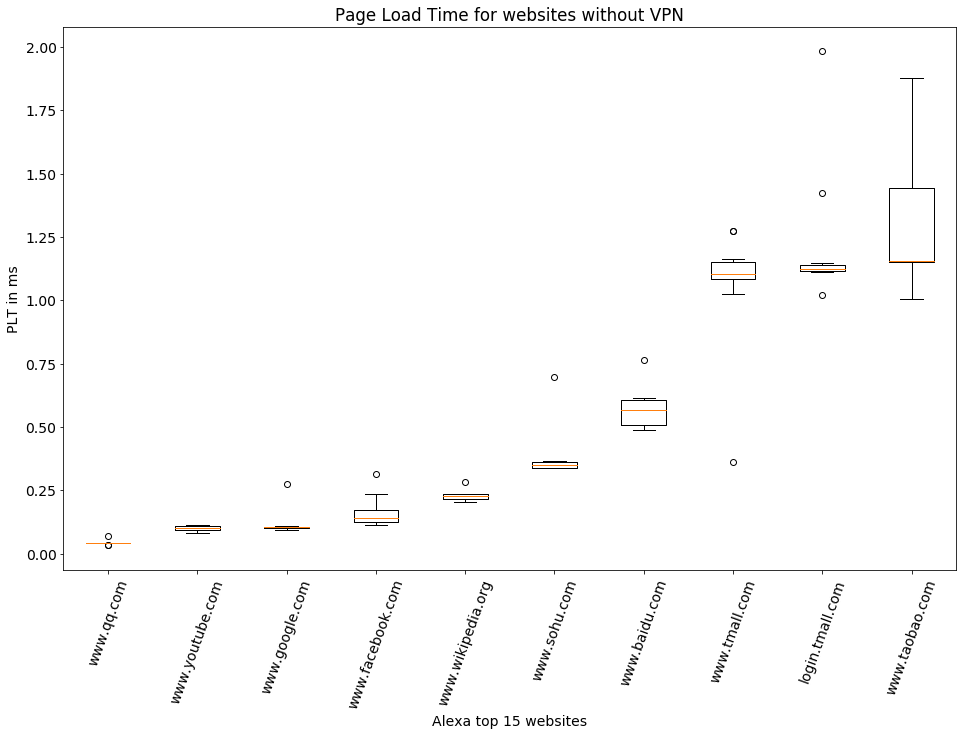

Average size of the Page being fetched: 

www.qq.com           ==>  236722.00
www.youtube.com      ==>  288584.50
www.google.com       ==>   12064.70
www.facebook.com     ==>  117492.30
www.wikipedia.org    ==>   83579.00
www.sohu.com         ==>  206166.20
www.baidu.com        ==>    2443.00
www.tmall.com        ==>  227693.00
login.tmall.com      ==>   13899.00
www.taobao.com       ==>  393906.00


In [51]:
# PLT without VPN
x_axes, plts, sizes = get_plt('novpn')

plt.rcParams.update({'font.size': 14})
fig, ax = plt.subplots(figsize=(16,10))

plt.xlabel('Alexa top 15 websites')
plt.ylabel('PLT in ms')
plt.title('Page Load Time for websites without VPN')
ax.set_xticklabels(x_axes)
plt.xticks(rotation=70)
plt.boxplot(plts)
plt.show()

print("Average size of the Page being fetched: ")
print()
for i,size in enumerate(sizes):
    print(("%-20s" % x_axes[i])+" ==> %10.2f" % np.mean(size))

**Analysing Google under different country codes**

We had selected the Google website with some of the most popular country codes as listed on the VPN service we were using. We had tested the PLT for these sites without VPN and with several VPN servers.

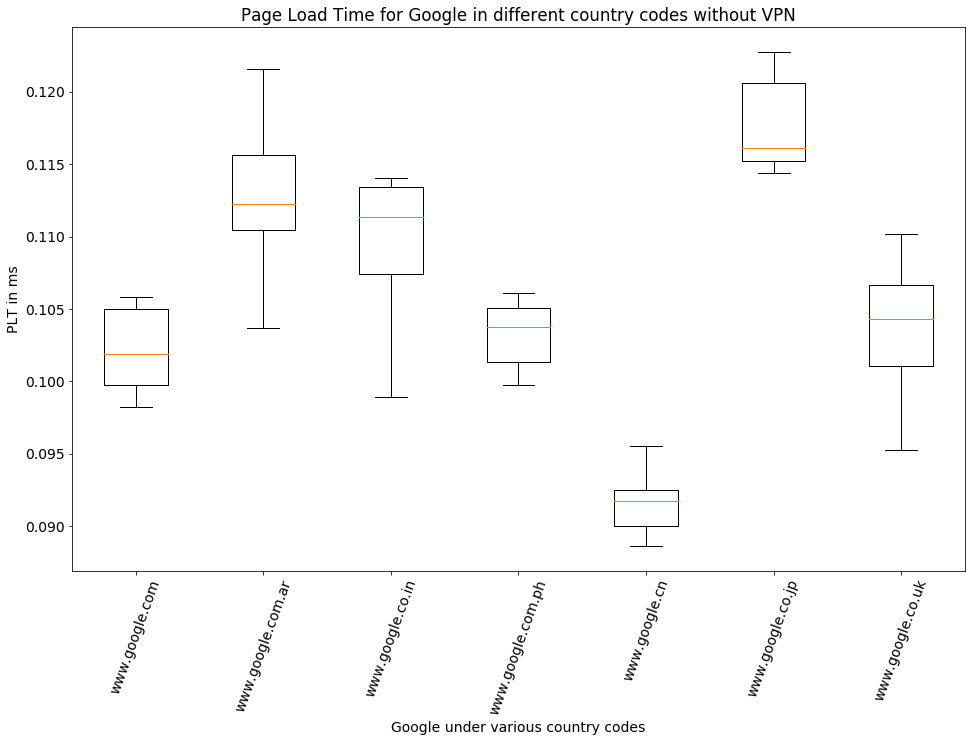

Average size of the Page being fetched: 

www.google.com       ==>   12049.10
www.google.com.ar    ==>   12815.80
www.google.co.in     ==>   12203.30
www.google.com.ph    ==>   12196.40
www.google.cn        ==>    3244.00
www.google.co.jp     ==>   12787.60
www.google.co.uk     ==>   12198.90


In [60]:
# PLT without VPN
x_axes, plts, sizes = get_plt('gl_novpn',False)

plt.rcParams.update({'font.size': 14})
fig, ax = plt.subplots(figsize=(16,10))

plt.xlabel('Google under various country codes')
plt.ylabel('PLT in ms')
plt.title('Page Load Time for Google in different country codes without VPN')
ax.set_xticklabels(x_axes)
plt.xticks(rotation=70)
plt.boxplot(plts, showfliers=False)
plt.show()

print("Average size of the Page being fetched: ")
print()
for i,size in enumerate(sizes):
    print(("%-20s" % x_axes[i])+" ==> %10.2f" % np.mean(size))

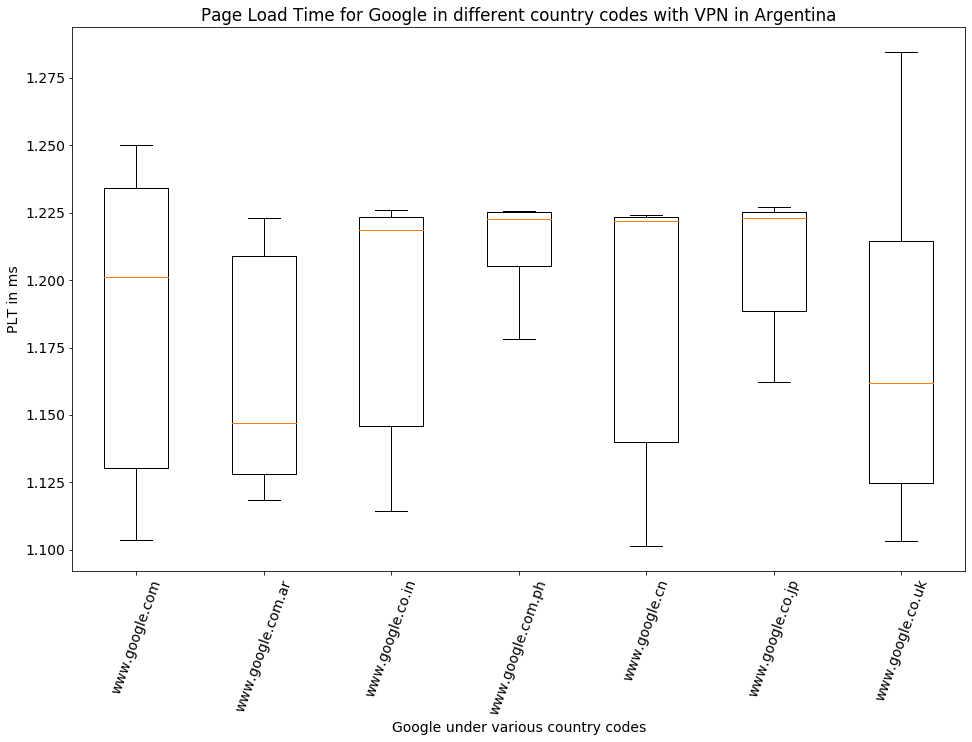

Average size of the Page being fetched: 

www.google.com       ==>   12843.30
www.google.com.ar    ==>   13529.30
www.google.co.in     ==>   12982.40
www.google.com.ph    ==>   12979.40
www.google.cn        ==>    3244.00
www.google.co.jp     ==>   13548.80
www.google.co.uk     ==>   12976.30


In [61]:
# PLT with VPN in Buenos Aires, Argentina
x_axes_ar, plts_ar, sizes_ar = get_plt('gl_bue',False)

plt.rcParams.update({'font.size': 14})
fig, ax = plt.subplots(figsize=(16,10))

plt.xlabel('Google under various country codes')
plt.ylabel('PLT in ms')
plt.title('Page Load Time for Google in different country codes with VPN in Argentina')
ax.set_xticklabels(x_axes_ar)
plt.xticks(rotation=70)
plt.boxplot(plts_ar, showfliers=False)
plt.show()

print("Average size of the Page being fetched: ")
print()
for i,size in enumerate(sizes_ar):
    print(("%-20s" % x_axes[i])+" ==> %10.2f" % np.mean(size))

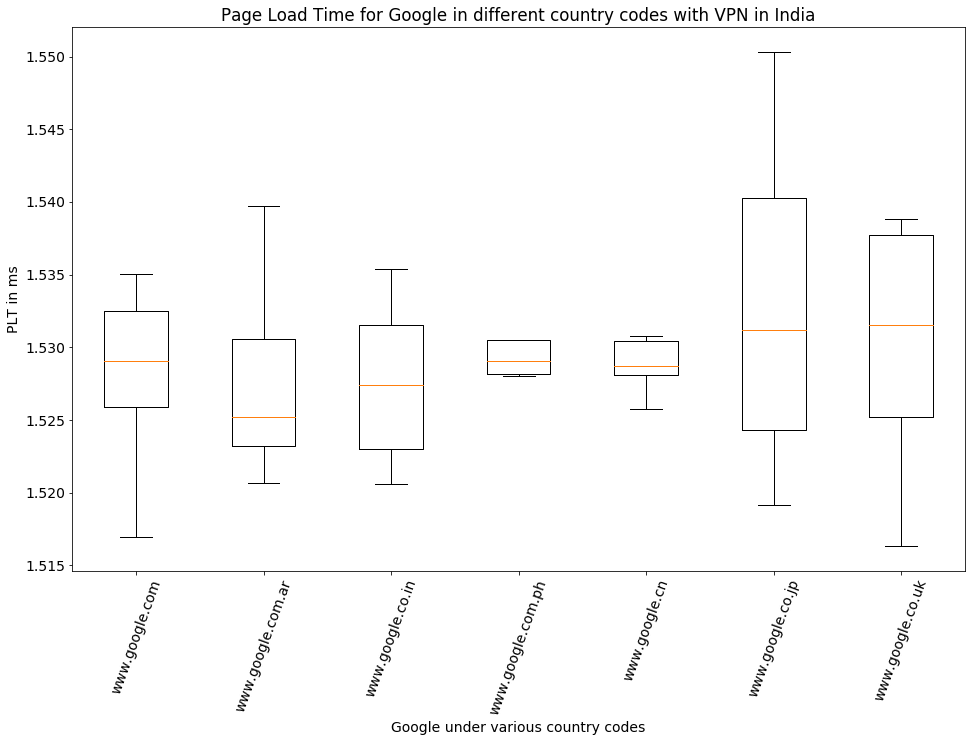

Average size of the Page being fetched: 

www.google.com       ==>   14632.60
www.google.com.ar    ==>   14649.60
www.google.co.in     ==>   14346.20
www.google.com.ph    ==>   14443.00
www.google.cn        ==>    3244.00
www.google.co.jp     ==>   14523.10
www.google.co.uk     ==>   14334.70


In [64]:
# PLT with VPN in Mumbai, India
x_axes_in, plts_in, sizes_in = get_plt('gl_ind',False)

plt.rcParams.update({'font.size': 14})
fig, ax = plt.subplots(figsize=(16,10))

plt.xlabel('Google under various country codes')
plt.ylabel('PLT in ms')
plt.title('Page Load Time for Google in different country codes with VPN in India')
ax.set_xticklabels(x_axes_in)
plt.xticks(rotation=70)
plt.boxplot(plts_in, showfliers=False)
plt.show()

print("Average size of the Page being fetched: ")
print()
for i,size in enumerate(sizes_in):
    print(("%-20s" % x_axes[i])+" ==> %10.2f" % np.mean(size))